# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


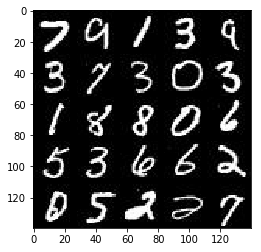

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

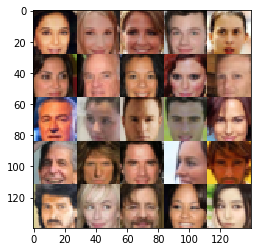

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    stddev = 0.02
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 
        x1 = tf.layers.conv2d(images, 32, 5, 1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x1 = tf.maximum(alpha * x1, x1)

        # Layer 2
        x2 = tf.layers.conv2d(x1, 64, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)

        # Layer 3
        x3 = tf.layers.conv2d(x2, 128, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3) 

        flattened = tf.reshape(x3, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1,kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1
    stddev=0.02
    with tf.variable_scope('generator', reuse=not is_train):
        
        # Layer 1
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        # Layer 2
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # Layer 3
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    model = generator(input_z, out_channel_dim)
    model_real, logits_real = discriminator(input_real)
    model_fake, logits_fake = discriminator(model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_real,labels=tf.ones_like(logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_fake,labels=tf.zeros_like(logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= logits_fake,labels=tf.ones_like( logits_fake)))
    
    return d_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_var = [var for var in train_vars if var.name.startswith('discriminator')]
    g_var = [var for var in train_vars if var.name.startswith('generator')]
    
    update = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_update_ops = [op for op in update if op.name.startswith('generator')]
    
    with tf.control_dependencies(generator_update_ops):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, gen_ops = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                i += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if i % print_every == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z,input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                    
                if i % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        saver.save(sess, './checkpoints/checkpoint.ckpt')

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.8232
Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 1.0721
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.9207
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.8847
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.8903


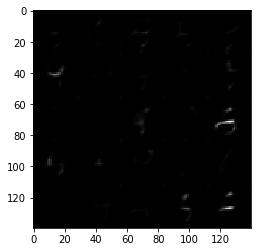

Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.8271
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: 0.7597


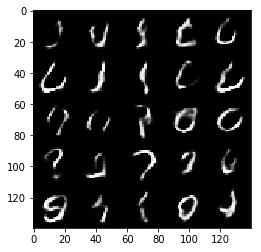

Epoch 1/2... Discriminator Loss: 1.3647... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.7493
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.7665
Epoch 1/2... Discriminator Loss: 1.4282... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.8092


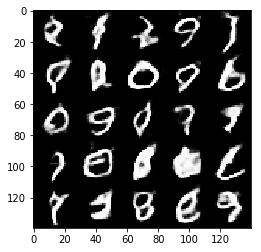

Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.7122
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.8338
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.8979
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.8589
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.7823
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 1.0458


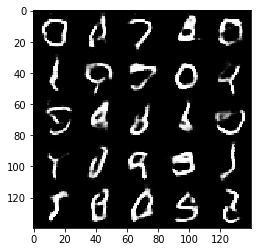

Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.8156
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.9015
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.7503
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.3512... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.6642


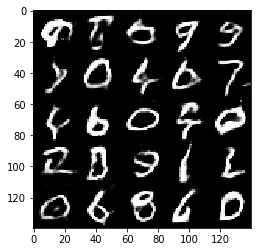

Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 1.1274
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 1.0810
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.9281
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.8156


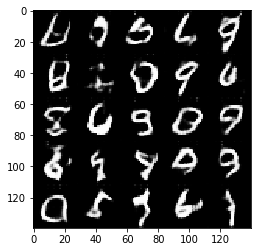

Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 1.0571
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.9547
Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 1.4957... Generator Loss: 1.3772
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.9134
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.4340
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 1.4057


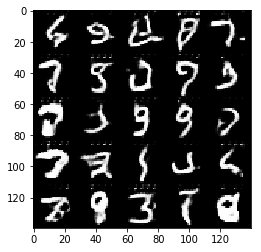

Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 1.3908
Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 1.2334
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 1.2255
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.9549
Epoch 1/2... Discriminator Loss: 1.0451... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 1.3299
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.7888
Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.1999... Generator Loss: 0.9732
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 1.1749


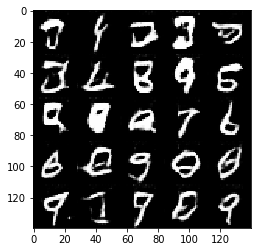

Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.0187
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 1.1236
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.0558
Epoch 1/2... Discriminator Loss: 0.8457... Generator Loss: 1.2487
Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 1.1137
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.6617
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.0785


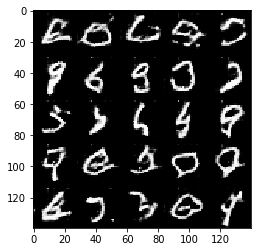

Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 1.0110
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.3219
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 0.8194
Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 1.5812
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.6631
Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 1.9404
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 1.6912
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 0.8881
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.0910


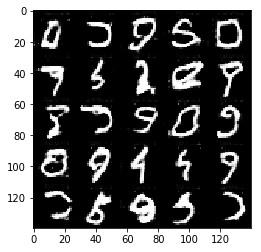

Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.3269
Epoch 1/2... Discriminator Loss: 0.7943... Generator Loss: 1.1844
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 1.3352
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.5183
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.1953
Epoch 1/2... Discriminator Loss: 1.4700... Generator Loss: 1.3026
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.1746
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.9459


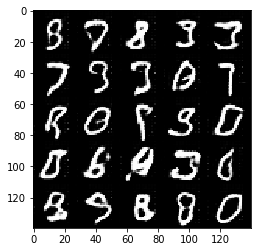

Epoch 1/2... Discriminator Loss: 0.8853... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 1.1127
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 0.5428
Epoch 1/2... Discriminator Loss: 0.7453... Generator Loss: 1.9555
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 0.9852
Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 1.0019
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.5121
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 1.0521


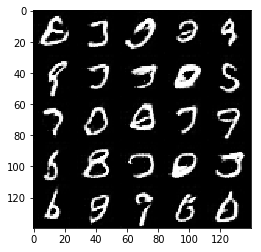

Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.8212
Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 0.9204
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 0.9904... Generator Loss: 1.2422
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 1.5027
Epoch 1/2... Discriminator Loss: 0.7939... Generator Loss: 1.6168
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.8937
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 1.4010
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.1887


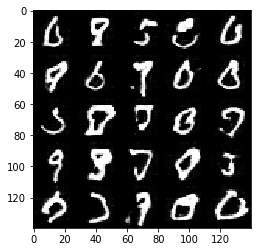

Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 1.3518
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.8340
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.5966
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 1.1217
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 0.8609
Epoch 1/2... Discriminator Loss: 1.1271... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 1.6080
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 1.0705
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 0.7609


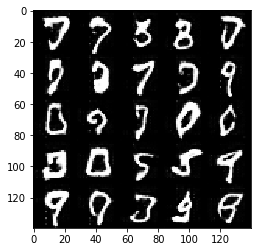

Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 1.5253
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 1.3582
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 1.5435
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 1.1945
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 1.4870
Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 1.1621
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.8333
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.0142


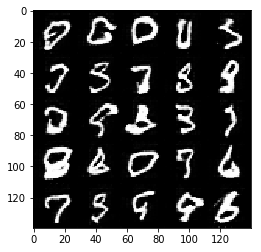

Epoch 1/2... Discriminator Loss: 0.8349... Generator Loss: 1.2714
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 1.9116
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.9845
Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 1.3977
Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 0.7688


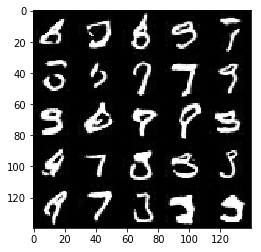

Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 0.9962
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.5437
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.9843
Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 1.0134
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 1.1231
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 1.8205
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.3512
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 1.2806
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.7742


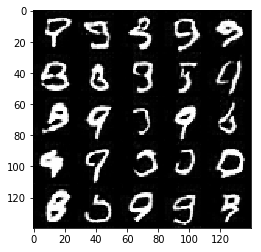

Epoch 1/2... Discriminator Loss: 1.0847... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 1.1088
Epoch 1/2... Discriminator Loss: 0.9541... Generator Loss: 1.2745
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 1.2166
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.7881
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.2327
Epoch 1/2... Discriminator Loss: 0.8082... Generator Loss: 1.7893
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 1.0870
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 1.7142
Epoch 1/2... Discriminator Loss: 0.7529... Generator Loss: 1.4296


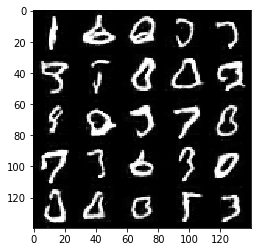

Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 1.5793
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 1.2691
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 1.8629
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.4823
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 0.8948
Epoch 1/2... Discriminator Loss: 1.2679... Generator Loss: 2.0890
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.1575
Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.7312
Epoch 2/2... Discriminator Loss: 0.8916... Generator Loss: 1.3037
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.9331


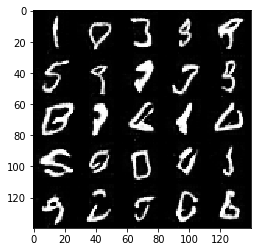

Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.2809
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 1.5786
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.3104
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 0.9572
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 1.3842
Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 1.2040
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.5260
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.1866
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 1.8830


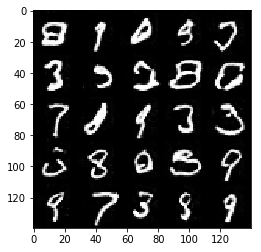

Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 1.4439
Epoch 2/2... Discriminator Loss: 0.7804... Generator Loss: 1.5585
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 1.1886
Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 1.7722
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.6013
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.7743


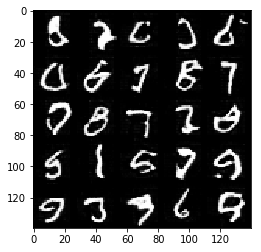

Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 1.0287
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 1.1690
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.1348
Epoch 2/2... Discriminator Loss: 0.9762... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 1.3133... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 1.3501
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 1.0130
Epoch 2/2... Discriminator Loss: 0.9640... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 0.9780


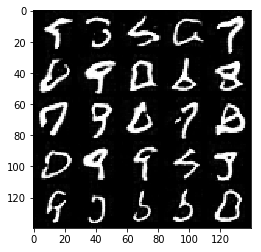

Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 1.2747
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.1940
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 1.4019
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 0.9142... Generator Loss: 1.1196
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 1.1151
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 1.3217
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.9936


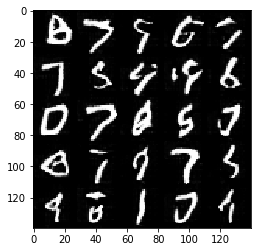

Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.5939
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 1.4834
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 1.0445
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 0.8831
Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 0.9594... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.4319
Epoch 2/2... Discriminator Loss: 0.9336... Generator Loss: 1.0002
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.4958


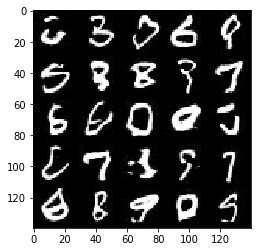

Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 1.1211
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 1.9521
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 1.1492
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.3421
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.3008
Epoch 2/2... Discriminator Loss: 0.9334... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.0901


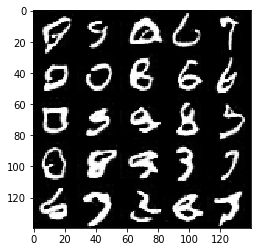

Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 1.5610
Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 1.1309
Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 1.6905
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 0.9505
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 0.8642... Generator Loss: 1.3319
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 1.4215
Epoch 2/2... Discriminator Loss: 0.7408... Generator Loss: 1.4567
Epoch 2/2... Discriminator Loss: 0.6243... Generator Loss: 1.8841


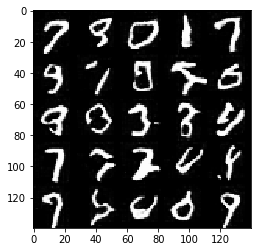

Epoch 2/2... Discriminator Loss: 0.7874... Generator Loss: 1.2362
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 0.6282... Generator Loss: 1.7960
Epoch 2/2... Discriminator Loss: 0.8540... Generator Loss: 1.1387
Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 1.5909
Epoch 2/2... Discriminator Loss: 0.7621... Generator Loss: 1.8868
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.3261
Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.3754
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.3191


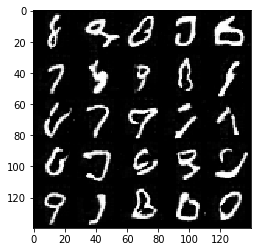

Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 1.6887
Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 1.2942
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 1.8935
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.3328
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 1.2655
Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 1.8328
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 0.8039
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 0.9639
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.7333


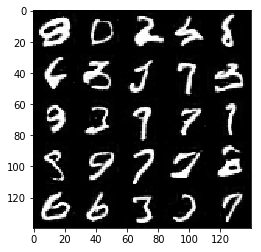

Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 1.2226
Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.2422
Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 1.5099
Epoch 2/2... Discriminator Loss: 0.7388... Generator Loss: 1.8122
Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.3125
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.7173
Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.1279
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.9669
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.2875


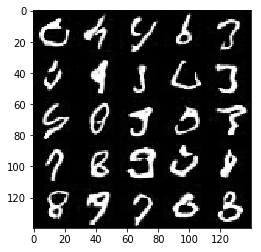

Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.1840
Epoch 2/2... Discriminator Loss: 0.8469... Generator Loss: 2.0086
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 1.2257
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 1.1588
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 1.1726
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.7309
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.2209
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.3632
Epoch 2/2... Discriminator Loss: 0.6533... Generator Loss: 1.6036


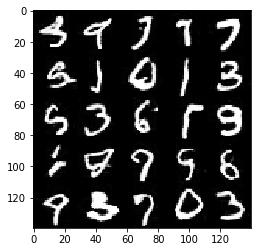

Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 1.0579
Epoch 2/2... Discriminator Loss: 0.7848... Generator Loss: 1.5185
Epoch 2/2... Discriminator Loss: 1.1115... Generator Loss: 1.6471
Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 1.1224
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 0.7234
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 1.2225
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.1259
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.5474


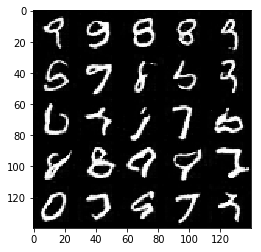

Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.7191
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 2.2157
Epoch 2/2... Discriminator Loss: 0.7483... Generator Loss: 1.5183
Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 2.0772
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 1.0731
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 1.5112
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 1.2914
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.2304


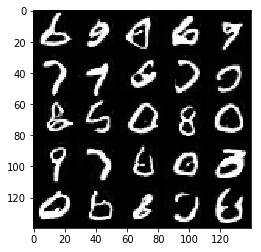

Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 1.0013
Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 1.7753
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.2758
Epoch 2/2... Discriminator Loss: 0.6846... Generator Loss: 1.8315
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 1.4659
Epoch 2/2... Discriminator Loss: 0.6563... Generator Loss: 1.7219
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 1.0943
Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 1.7226
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.5741


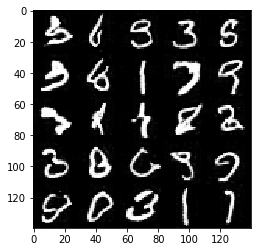

Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 1.0562
Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 1.5570
Epoch 2/2... Discriminator Loss: 0.9341... Generator Loss: 1.0416
Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.7639
Epoch 2/2... Discriminator Loss: 0.7152... Generator Loss: 1.4464
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 0.8753
Epoch 2/2... Discriminator Loss: 0.5928... Generator Loss: 1.8012
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 2.5155
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 0.9752
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 1.0554


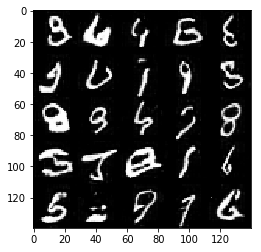

Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 2.0017
Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 1.5465
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.5630
Epoch 2/2... Discriminator Loss: 1.1518... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 1.9073
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.0146
Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 0.8951
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 1.3885
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 1.0359


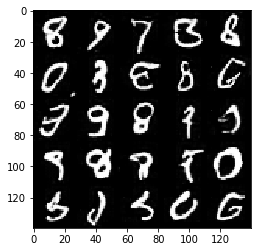

Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.8014
Epoch 2/2... Discriminator Loss: 1.0312... Generator Loss: 0.9288
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.7587
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 1.0094
Epoch 2/2... Discriminator Loss: 0.7483... Generator Loss: 1.4857
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.1691
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.7446
Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 1.3219
Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 1.1074


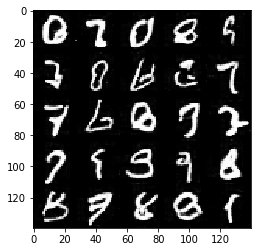

Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 1.1289
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.6433
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.7366
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 0.9462
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 1.0068
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 1.1666
Epoch 2/2... Discriminator Loss: 0.9138... Generator Loss: 1.1576
Epoch 2/2... Discriminator Loss: 1.7562... Generator Loss: 1.3387
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 1.5371
Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 2.1568


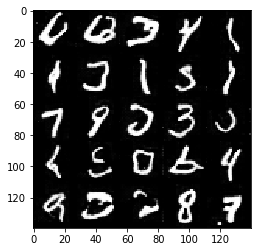

Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 0.9937
Epoch 2/2... Discriminator Loss: 0.6983... Generator Loss: 1.5566
Epoch 2/2... Discriminator Loss: 0.9700... Generator Loss: 0.9933
Epoch 2/2... Discriminator Loss: 0.6813... Generator Loss: 1.6473


In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6320... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7636


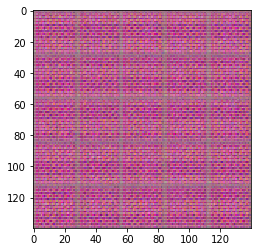

Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.9495


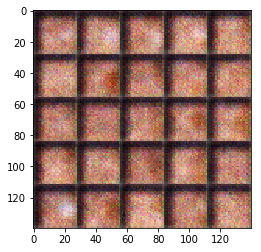

Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.9408


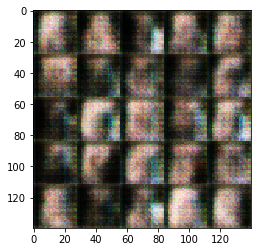

Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.2024
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.9780


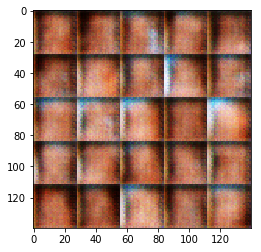

Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.6107
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.5282
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.3136


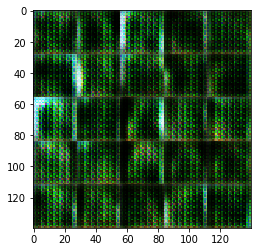

Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.7663
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 2.1297
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.6512
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.4955
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.7968


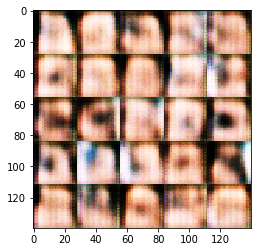

Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 2.1976
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.7434
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.3667


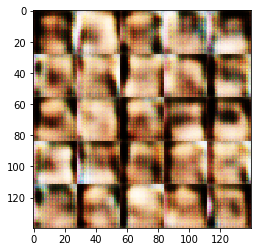

Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 2.4628
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 2.2872
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 2.2919
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.9073
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 2.8152
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.3892
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.3359


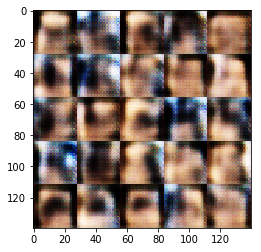

Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.7814
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.7594
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 1.6621
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 2.6770
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.3314


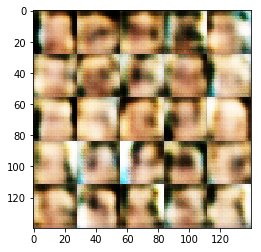

Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 2.8828
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.6024
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 0.7144... Generator Loss: 2.3036
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 2.5397
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 1.4824
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 2.3051


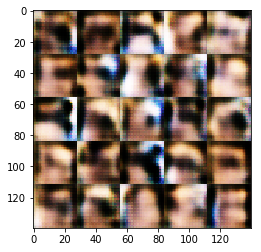

Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.6179
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 1.9313
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.9837
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 2.4970
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.3354
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.1575


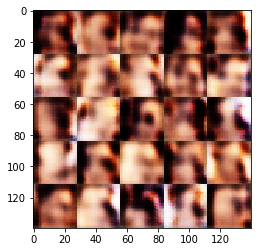

Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.8795
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.8196
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.7650
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.7620


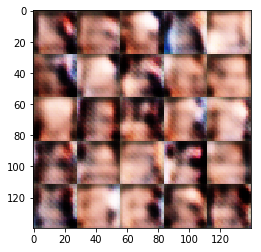

Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 1.6941
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.5968
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.6317
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 0.7284... Generator Loss: 1.7256
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.8464
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.2920
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 1.3504


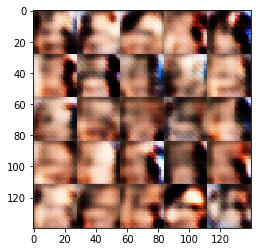

Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.8583
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 1.8163
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.4075
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.2230
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.4930
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 1.9769


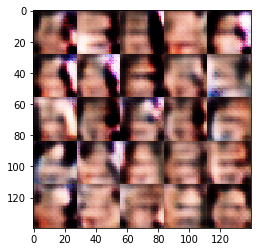

Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.3928
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 2.1416
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 2.1805
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 2.6371
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.9005
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 0.7033... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.2125
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.5538


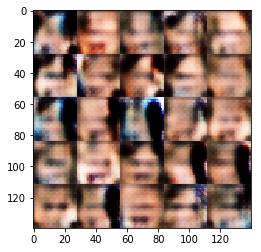

Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 1.7749
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 2.4801
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.5648
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 1.8887
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 1.5817
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.4053
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.6740
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 2.4605


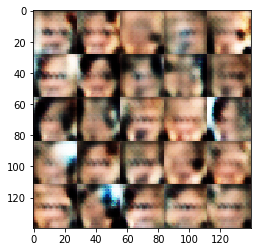

Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.8297
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.4286
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.7310
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 2.5096
Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 2.1218
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.3805
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 2.7011
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 2.0780
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 2.9463
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.2625


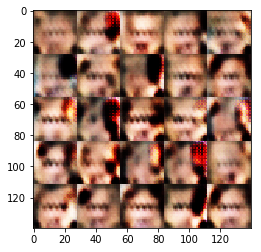

Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.7474
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 1.9711
Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 2.4497
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.5629
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 1.6440
Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 1.5042
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 2.1829


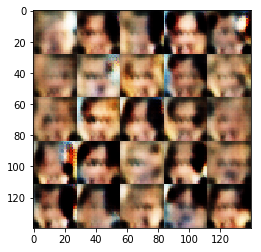

Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 2.4082
Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 2.3519
Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 2.5651
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 3.0023
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.7131
Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 1.7877
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 1.8396
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 1.5039


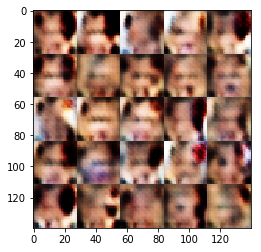

Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.9311
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 1.7344
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 1.4545
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.7613
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 1.9879
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 1.7964
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 2.1366
Epoch 1/1... Discriminator Loss: 0.5637... Generator Loss: 2.7722


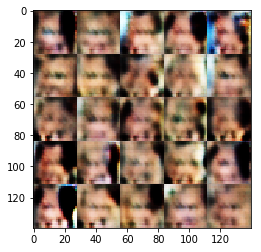

Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.6957
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.5372
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 2.2956
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 2.3411
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 2.0182
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 1.8753
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 2.1655
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 2.0963


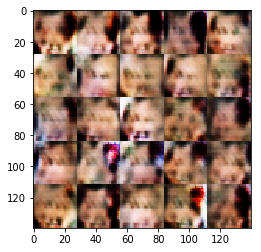

Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 1.6507
Epoch 1/1... Discriminator Loss: 0.6590... Generator Loss: 1.5120
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 1.5680
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.2642
Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 1.8336
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.6160
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 2.3198
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 2.1865
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.8250


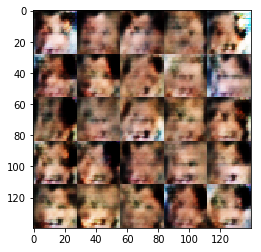

Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 1.6503
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.4366
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.4766
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.7425
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.7309
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.4975
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.6098
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.5797


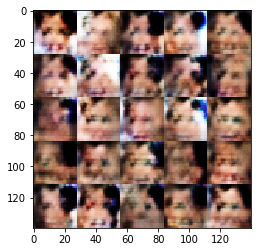

Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.5030
Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 2.5997
Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 1.6050
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 2.7679
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 1.9715
Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 2.2160
Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 1.9870
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 2.1398
Epoch 1/1... Discriminator Loss: 2.4270... Generator Loss: 1.7934


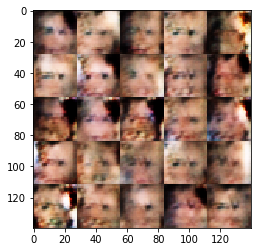

Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 1.6323
Epoch 1/1... Discriminator Loss: 0.6563... Generator Loss: 1.8956
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.8455
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 0.7628... Generator Loss: 1.5814
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.4072
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.6604


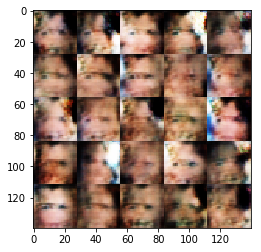

Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.5421
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 2.1331
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.6194
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.9633
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.4264
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.3257
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.2335


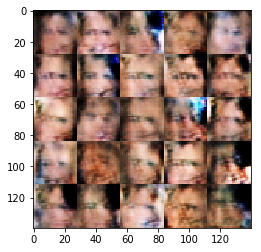

Epoch 1/1... Discriminator Loss: 0.7105... Generator Loss: 1.6867
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.8353
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.0209
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.2321
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.8816
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.8716
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.6916
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.7441


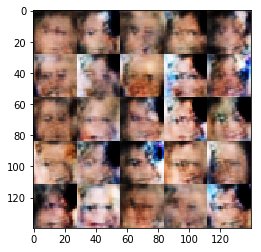

Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 2.4180
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.5655
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.5732
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 1.8437


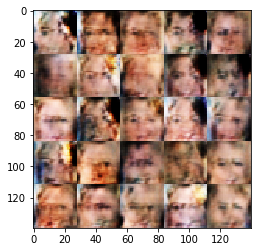

Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.8154
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 2.3601
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.9421
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.5310
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.5769


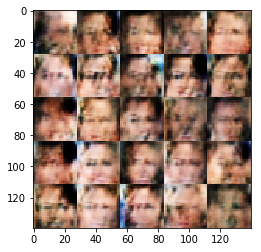

Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.7273
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.8952
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.2195
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.9504
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.1835


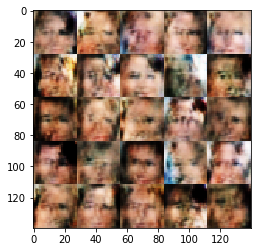

Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.4286
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.7397
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.5551
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.3297
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.2299
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 1.7634
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.3048


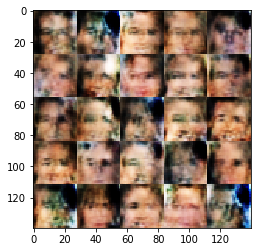

Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 1.3478
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.6143
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.6915
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.2882


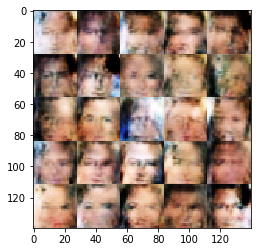

Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.4913
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.7575
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.4846
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.5133
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 1.9342
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.1318


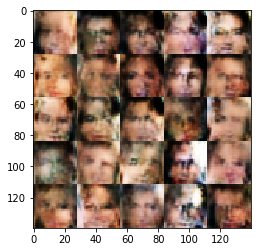

Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.6047
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 2.2003
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.6146
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 2.3303
Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 1.7685
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.4736


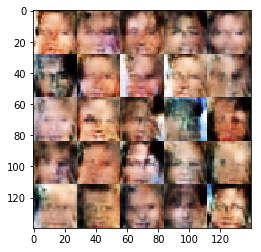

Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.7936
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.3756
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.2589
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.2175


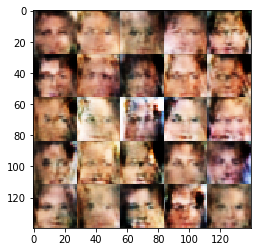

Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.6687
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 2.3763
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.7048
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.9009


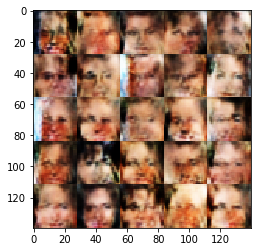

Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 2.1674
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.4661
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.6514
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.3724
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.5732
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.1698


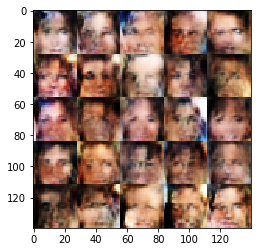

Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.7571
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 2.6514
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.7845
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 3.1943
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.2747


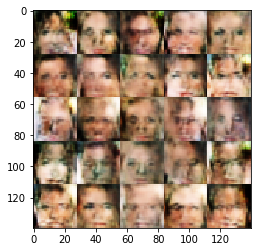

Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.4977
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 1.2385
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.7921
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.7041
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 1.3333


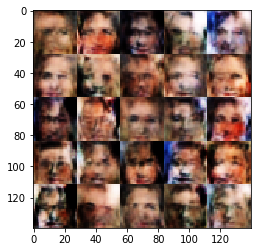

Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 2.2107
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 2.3414
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 1.7613
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.8905
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 2.0738


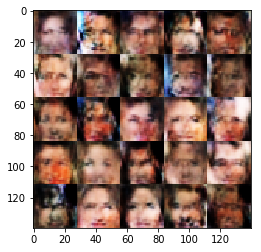

Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.7152
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.8415
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.7504
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.0765


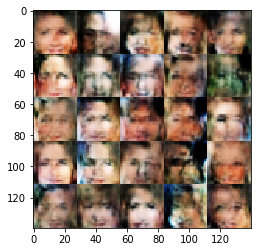

Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.5397
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 2.0700
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.5588
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.9347


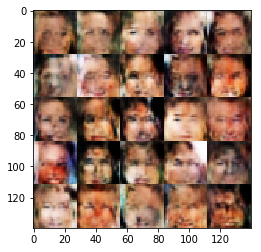

Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.6516
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 1.5063
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.9172
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.8656
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.2001


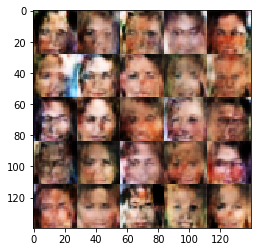

Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.6912
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 1.3960
Epoch 1/1... Discriminator Loss: 2.2832... Generator Loss: 2.6022
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 2.1459


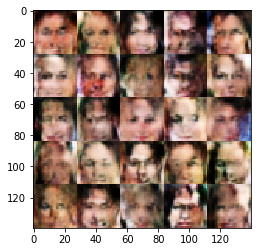

Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.4632
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 1.5681
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.4165
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.1507
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.5773
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 1.4397
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.3555


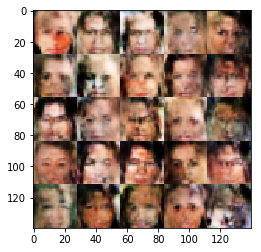

Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.5195
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.3637
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.5514
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.3114
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.4559
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.5308


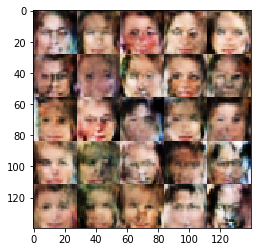

Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.4135
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.5881
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.7646
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 2.3808
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.6645
Epoch 1/1... Discriminator Loss: 2.3763... Generator Loss: 1.9936
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 1.0735


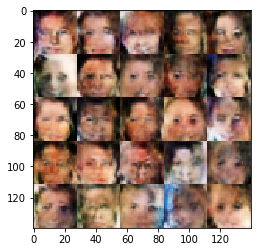

Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.7464
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 2.0107
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.5304
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 2.2473


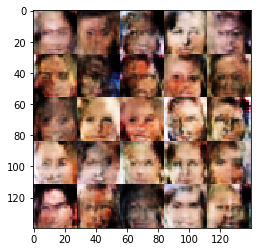

Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.8109
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.4118
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 2.3987
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.4647
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 2.8257
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.3433
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.4994
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.3471


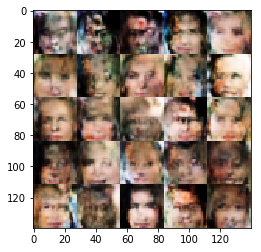

Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.7809
Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 1.6743
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.7473
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.3743
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.7638


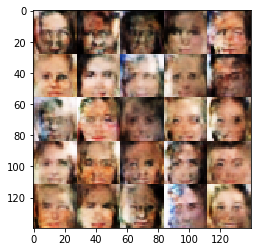

Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 1.9661
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.6383
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 1.9315
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.7757
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 2.1224
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 2.0229
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 1.4165


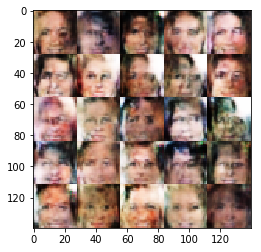

Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.3904
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.6938
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 2.3630
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.4965
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.7114


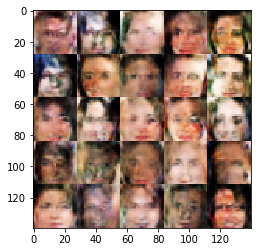

Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.9085
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 1.8686
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.5023
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 2.0453
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.7240
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.2706
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.7236... Generator Loss: 1.5392


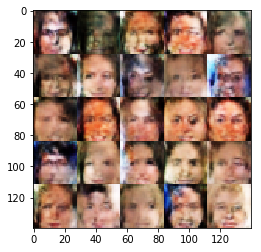

Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 2.4059
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 2.0538
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.6319
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.8065
Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 1.3798
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.4524
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.8886


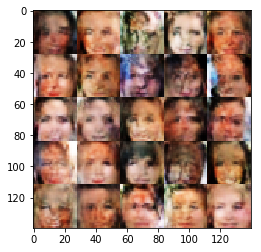

Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 2.1645
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.4326
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 2.0415
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.3394
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.3989
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.7658


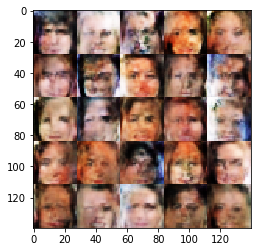

Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 2.0225
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 1.4012
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.7019


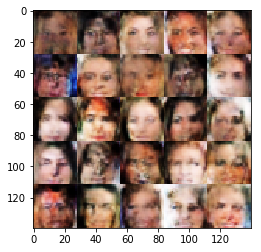

Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.3467
Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 2.1413
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.4665
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.9685
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.5882


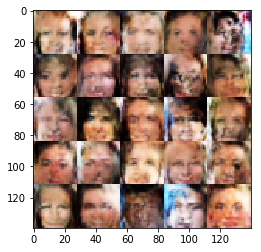

Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.5516
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.5712
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.8639
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.6204
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.6783
Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 1.3432
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 2.0224


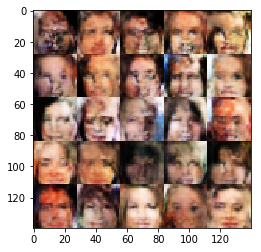

Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.5765
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.6724
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.9770
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 2.9785


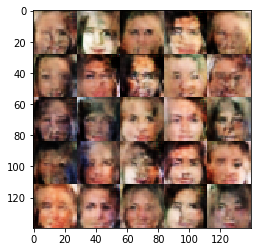

Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.5841
Epoch 1/1... Discriminator Loss: 0.7394... Generator Loss: 1.9217
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.1664
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.3387
Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 1.8834
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.4631
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 1.6562
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.5658
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.2845


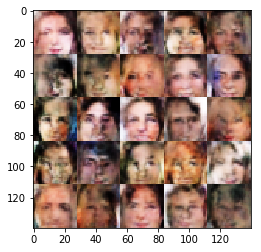

Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.3687
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.7374
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.3719
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.9850
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.3839
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 2.7959... Generator Loss: 2.8025


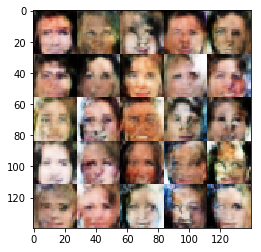

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.9932


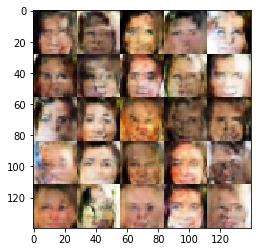

Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.1673


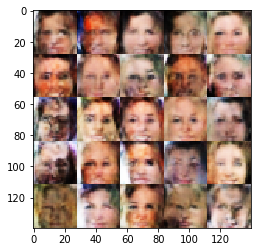

Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.9461


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.